In [ ]:
# 1. Importação de Bibliotecas Necessárias

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. Funções Utilitárias
# 2.1. Função para Obter Todos os Caminhos de Entrada

def get_all_input_paths(base_path):
    input_paths = []
    # Caminhar recursivamente pelas pastas
    for root, dirs, files in os.walk(base_path):
        if "imputed" in root:
            input_paths.append(root)
    return input_paths

# Obter os diretórios de experimentos
dirs = np.sort(get_all_input_paths('./imputation_Statistics/experiments'))
experiment_dirs = []
for experiment in dirs:
    base = experiment.split('/')
    experiment_dirs.append("/".join(base[:5]))
experiment_dirs = list(np.unique(experiment_dirs))

# 2.2. Função para Calcular Valores Mínimos e Máximos para Normalização
def compute_min_max_values(experiment_dirs, wind):
    """
    Computa o mínimo e máximo globais para normalizar os dados de entrada.
    """
    all_train_data = []

    for base_dir in experiment_dirs:
        # Carregar os dados de treino para calcular o min e o max
        train_file = os.path.join(base_dir, 'treino', 'imputed', 'data_full_processed.csv')
        if not os.path.exists(train_file):
            continue  # Pular se o arquivo não existir
        train_data = pd.read_csv(train_file)

        # Obter apenas as colunas de entrada (val_real_*)
        input_columns = [f"val_real_{i}" for i in range(wind)]
        available_columns = train_data.columns.tolist()
        missing_columns = set(input_columns) - set(available_columns)
        if missing_columns:
            print(f"Colunas faltantes no experimento {base_dir}: {missing_columns}")
            continue  # Pular este experimento se as colunas não existirem

        train_inputs = train_data[input_columns].values

        all_train_data.append(train_inputs)

    if len(all_train_data) == 0:
        raise ValueError("Nenhum dado de treinamento encontrado para calcular min/max.")

    # Concatenar os dados de todos os experimentos (neste caso, apenas um)
    all_train_data = np.vstack(all_train_data)

    # Calcular o mínimo e o máximo global (para todas as características)
    min_values = np.nanmin(all_train_data, axis=0)
    max_values = np.nanmax(all_train_data, axis=0)

    return min_values, max_values


# 3. Definição da Classe ExperimentDataset com Normalização e Balanceamento


class ExperimentDataset(Dataset):
    def __init__(self, base_dir, mode='treino', wind=48, min_values=None, max_values=None):
        """
        Inicializa o dataset lendo os dados da pasta base_dir, aplica a normalização Min-Max e realiza o balanceamento das classes.
        """
        # Verificar se estamos no modo de treino ou teste
        assert mode in ['treino', 'teste'], "O modo precisa ser 'treino' ou 'teste'"

        # Montar o caminho correto para treino ou teste
        data_file = os.path.join(base_dir, mode, 'imputed', 'data_full_processed.csv')

        # Verificar se o arquivo existe
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"O arquivo {data_file} não foi encontrado.")

        # Carregar o CSV
        self.data = pd.read_csv(data_file)
        self.data = self.data.reset_index(drop=True)  # Resetar o índice para garantir que seja sequencial

        # Definir as colunas de entrada e as multilabels
        self.input_columns = [f"val_real_{i}" for i in range(wind)]  # As primeiras 'wind' colunas são os dados de entrada
        self.multiclass_column = 'multiclass'  # Coluna multiclass
        self.multilabel_columns = [col for col in self.data.columns if 'multabel' in col]  # Colunas multilabel

        # Preencher NaN com a média da coluna nos dados de entrada
        for col in self.input_columns:
            mean_value = self.data[col].mean()
            self.data[col] = self.data[col].fillna(mean_value)

        # Normalizar os dados de entrada usando Min-Max (se min_values e max_values forem fornecidos)
        if min_values is not None and max_values is not None:
            for i, col in enumerate(self.input_columns):
                self.data[col] = (self.data[col] - min_values[i]) / (max_values[i] - min_values[i] + 1e-3)  # Para evitar divisão por zero

        # Garantir que os rótulos multiclass sejam inteiros
        self.data[self.multiclass_column] = self.data[self.multiclass_column].astype(int)

        # Obter os rótulos únicos e ajustar para começar em 0
        unique_labels = self.data[self.multiclass_column].unique()
        min_label = unique_labels.min()
        max_label = unique_labels.max()
        self.data[self.multiclass_column] -= min_label  # Ajustar os rótulos para começar em 0

        # Atualizar o número de classes
        self.n_multiclass_classes = max_label - min_label + 1

        if mode == 'treino':
            # Contar o número de amostras por classe
            class_counts = self.data[self.multiclass_column].value_counts()
          

            # Criar uma lista para armazenar DataFrames balanceados
            balanced_data = []

            # Adiciona todas as classes ao balanced_data, independentemente do valor
            new=None
            for cls in class_counts.index:
                cls_data = self.data[self.data[self.multiclass_column] == cls]
                balanced_data.append(cls_data)

                # Apenas duplica as classes com contagem menor que a mediana
                # Se a duplicação for necessária
                if class_counts[cls] < 30 and class_counts[cls] > 0:
                    # Inverte as séries temporais nas colunas de entrada para criar a versão espelhada
                    cls_data_inverted = cls_data.copy()
                    cls_data_inverted[self.input_columns] = cls_data[self.input_columns].apply(lambda row: row[::-1], axis=1)

                    # Concatena a classe invertida à coluna de rótulos `multiclass_column`
                    if new is None:
                        new = cls_data_inverted  # Cria `new` na primeira iteração
                    else:
                        new = pd.concat([new, cls_data_inverted], axis=0, ignore_index=True)

            # Junta todas as classes em um único DataFrame final
            self.data = pd.concat([self.data,new], axis=0,ignore_index=True)
            self.data[self.multiclass_column] = self.data[self.multiclass_column].astype(int)

            # Embaralhar os dados
            # self.data = self.data.sample(frac=1, random_state=42).reset_index(drop=True)

        else:
            # Se estiver no modo de teste, não balancear as classes
            self.data = self.data.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retorna os dados de entrada e os alvos para o índice dado.
        """
        # Dados de entrada
        input_data = self.data.iloc[idx][self.input_columns].values.astype(np.float32)
        input_data = input_data[:, np.newaxis]  # Adicionar dimensão de canal

        # Multilabel alvo (usada no treinamento)
        multilabel_target = self.data.iloc[idx][self.multilabel_columns].values.astype(np.float32)

        # Multiclass alvo (usada no teste)
        multiclass_target = int(self.data.iloc[idx][self.multiclass_column])

        return torch.tensor(input_data), torch.tensor(multilabel_target), torch.tensor(multiclass_target)


# 4. Função para Carregar Dados de um Único Experimento
from torch.utils.data import random_split, Subset

def load_single_experiment_data(experiment_dir, wind, batch_size, min_values=None, max_values=None, val_split=0.1, random_seed=42):
    # Criar o dataset completo de treinamento
    full_train_dataset = ExperimentDataset(experiment_dir, mode='treino', wind=wind, min_values=min_values, max_values=max_values)
    
    # Determinar o tamanho do conjunto de validação
    val_size = int(len(full_train_dataset) * val_split)
    train_size = len(full_train_dataset) - val_size
    
    # Definir a seed para reprodutibilidade
    generator = torch.Generator().manual_seed(random_seed)
    
    # Dividir o dataset em treino e validação
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size], generator=generator)
    
    # Criar o dataset de teste
    test_dataset = ExperimentDataset(experiment_dir, mode='teste', wind=wind, min_values=min_values, max_values=max_values)
    
    # Criar data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader



# 5. Definição da Classe CustomModel com Saídas Separadas

class HybridLSTM(nn.Module):
    def __init__(self, seq_len, n_multilabel_classes, n_multiclass_classes, filters=64, filterslstm=30,
                 num_rnn_layers=2, num_conv_layers=6, kernel_size=2, dense_neurons=80, dp=0.5):
        super(HybridLSTM, self).__init__()

        self.rnn_layers = nn.ModuleList()

        # Primeira camada LSTM bidirecional
        self.rnn_layers.append(
            nn.LSTM(input_size=1, hidden_size=filterslstm, batch_first=True, bidirectional=True,
                    dropout=dp if num_rnn_layers > 1 else 0.0)
        )

        # LSTMs subsequentes unidirecionais
        for i in range(1, num_rnn_layers):
            # A saída da primeira camada bidirecional terá 2 * hidden_size
            self.rnn_layers.append(
                nn.LSTM(input_size=filterslstm * 2, hidden_size=filterslstm, batch_first=True, bidirectional=False,
                        dropout=dp if num_rnn_layers > 1 else 0.0)
            )

        # Ajustando o tamanho da camada de normalização
        self.layer_norm_lstm = nn.LayerNorm(filterslstm)

        # Definindo as camadas convolucionais
        conv_layers = []
        for i in range(num_conv_layers):
            in_channels = 1 if i == 0 else filters
            conv_layers += [
                nn.Conv1d(in_channels, filters, kernel_size, stride=2, padding=kernel_size // 2),
                nn.BatchNorm1d(filters),
                nn.ReLU(inplace=True),
                nn.Dropout(dp)
            ]
        self.conv_layers = nn.Sequential(*conv_layers)

        # Calculando o tamanho da saída convolucional corretamente
        self.conv_output_size = self._get_conv_output_size(seq_len)

        # Camadas densas após convolução
        self.dense_conv = nn.Linear(self.conv_output_size, dense_neurons)
        self.act_dense_conv = nn.ReLU(inplace=True)

        # Definindo o tamanho de saída da última LSTM (unidirecional)
        lstm_output_size = filterslstm * seq_len

        # Concatenando as saídas de LSTM e convolução
        final_input_size = lstm_output_size + dense_neurons

        # Camadas de saída
        self.multilabel_output = nn.Linear(final_input_size, n_multilabel_classes)
        self.multiclass_output = nn.Linear(final_input_size, n_multiclass_classes)

    def _get_conv_output_size(self, seq_len):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, seq_len)  # (batch_size, num_channels, sequence_length)
            output = self.conv_layers(dummy_input)
            return output.numel()  # Número total de elementos na saída convolucional

    def forward(self, x):
        # Caminho convolucional
        x_conv = x.clone().permute(0, 2, 1)  # Mudando para (batch_size, num_canais, comprimento)
        x_conv = self.conv_layers(x_conv)
        x_conv = x_conv.view(x_conv.size(0), -1)  # Achatar a saída convolucional
        x_conv = self.act_dense_conv(self.dense_conv(x_conv))

        # Caminho LSTM
        lstm_out, _ = self.rnn_layers[0](x)  # Primeira LSTM bidirecional
        for rnn in self.rnn_layers[1:]:
            lstm_out, _ = rnn(lstm_out)  # LSTMs subsequentes unidirecionais

        # Normalizando a saída da última LSTM
        lstm_out = self.layer_norm_lstm(lstm_out)
        lstm_out = lstm_out.contiguous().view(lstm_out.size(0), -1)  # Achatar a saída LSTM

        # Concatenando as saídas LSTM e convolucional
        x_concat = torch.cat([lstm_out, x_conv], dim=1)

        # Saídas finais
        return self.multilabel_output(x_concat), self.multiclass_output(x_concat)
# 6. Definição da Classe EarlyStopping



In [ ]:

# 7. Configuração do Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loop Principal de Treinamento
resultados = []
for experiment_dir in experiment_dirs:
    wind = int(experiment_dir.split('/')[-1])
    batch_size = 512  # Ajuste conforme necessário

    # Verificar se os arquivos de dados existem
    train_file = os.path.join(experiment_dir, 'treino', 'imputed', 'data_full_processed.csv')
    test_file = os.path.join(experiment_dir, 'teste', 'imputed', 'data_full_processed.csv')
    if not os.path.exists(train_file) or not os.path.exists(test_file):
        print(f"Dados não encontrados para o experimento: {experiment_dir}")
        continue

    # Calcular valores mínimos e máximos para normalização usando apenas o experimento atual
    min_values, max_values = compute_min_max_values([experiment_dir], wind=wind)

    # Carregar DataLoaders de treino, validação e teste
    train_loader, val_loader, test_loader = load_single_experiment_data(
        experiment_dir, wind=wind, batch_size=batch_size,
        min_values=min_values, max_values=max_values,
        val_split=0.1, random_seed=42
    )

    # Obter o número de classes
    n_multilabel_classes = train_loader.dataset.dataset[0][1].shape[0]
    n_multiclass_classes = train_loader.dataset.dataset.n_multiclass_classes

    print(f"Experimento: {experiment_dir}")
    # print("Número de classes multiclass:", n_multiclass_classes)
    # print("Número de classes multilabel:", n_multilabel_classes)

    # Instanciar o modelo com o número correto de classes
    n_multilabel_classes = train_loader.dataset.dataset[0][1].shape[0]
    n_multiclass_classes = train_loader.dataset.dataset.n_multiclass_classes

    model = HybridLSTM(wind, n_multilabel_classes, n_multiclass_classes).to(device)

    # Definir as funções de perda
    criterion_multilabel = nn.BCEWithLogitsLoss().to(device)  # Usando BCEWithLogitsLoss para maior estabilidade
    criterion_multiclass = nn.CrossEntropyLoss().to(device)  # Para classificação multiclass

    # Diretório para salvar os modelos
    model_dir = 'models'

    # Early Stopping com caminho atualizado
    model_path = os.path.join(model_dir, f"best_model_{experiment_dir.replace('/', '_')}_wind_{wind}.pt")
  
    # Carregar o melhor modelo salvo pelo early stopping
    model.load_state_dict(torch.load(model_path,weights_only=True))
    model.eval()

    # Avaliação Final no Conjunto de Teste

    test_loss = 0
    correct_multiclass_test = 0
    total_multiclass_test = 0
    # multilabel_outputs_test = []
    # multilabel_targets_test = []
    
    with torch.no_grad():

        multiclass_outputs_test = []
        multiclass_targets_test = []

        for batch_x, batch_y_multilabel, batch_y_multiclass in test_loader:
            batch_x = batch_x.to(device)
            batch_y_multilabel = batch_y_multilabel.to(device)
            batch_y_multiclass = batch_y_multiclass.to(device)

            outputs_multilabel, outputs_multiclass = model(batch_x)
            
        
            # Perda de teste para multilabel
            loss_multilabel = criterion_multilabel(outputs_multilabel, batch_y_multilabel)
            test_loss += loss_multilabel.item()

            # Coletar saídas e alvos para calcular o F1 Score
            # multilabel_outputs_test.append(outputs_multilabel.cpu().numpy())
            # multilabel_targets_test.append(batch_y_multilabel.cpu().numpy())

            # Precisão multiclass
            _, predicted_multiclass = torch.max(outputs_multiclass, 1)
            correct_multiclass_test += (predicted_multiclass == batch_y_multiclass).sum().item()
            total_multiclass_test += batch_y_multiclass.size(0)

            # Armazenando as saídas e alvos multiclass
            multiclass_outputs_test.append(predicted_multiclass.cpu().numpy())
            multiclass_targets_test.append(batch_y_multiclass.cpu().numpy())
            
        multiclass_outputs_test = np.concatenate(multiclass_outputs_test)
        multiclass_targets_test = np.concatenate(multiclass_targets_test)

        test_loss /= len(test_loader)
        test_loss /= len(test_loader)
        accuracy_multiclass_test = 100 * correct_multiclass_test / total_multiclass_test

        print(f"Teste Loss: {test_loss:.4f}, Multiclass Test Accuracy: {accuracy_multiclass_test:.2f}%, ")

        data_file = os.path.join(experiment_dir, 'teste', 'imputed', 'data_full_processed.csv')
        data = pd.read_csv(data_file)
        smapes = data[[col for col in data.columns if 'smape' in col]]

        pred = np.array([smapes.iloc[i,y] for i , y in enumerate(multiclass_outputs_test)])
        real = np.array([smapes.iloc[i,y] for i , y in enumerate(multiclass_targets_test)])
        worst = np.max(smapes.to_numpy(), axis=1)

   
        # Criar o DataFrame `df_result` a partir dos arrays `pred` e `real`
        df_result = pd.DataFrame({'pred_window': pred, 'best_window': real, 'worst': worst})
        df_result['serie'] = data['serie']

        # Agrupar e calcular a média em 'df_result'
        df_result1 = df_result.groupby('serie').mean()

        # Selecionar apenas colunas de 'smape' e a coluna 'serie'
        df = data[[col for col in data.columns if 'smape' in col] + ['serie']]

        # Calcular a média e o valor mínimo para cada série
        full_serie_min_values = df.groupby('serie').mean().min(axis=1)

        # Certificar que o índice do 'full_serie_min_values' e 'df_result1' correspondem
        df_result1['full_serie'] = full_serie_min_values.reindex(df_result1.index)
        df_result1.to_csv(experiment_dir+'/test_result.csv')
        # Imprimir o resultado final
        # print(df_result1.head(15))
        # resultados.append([df_result1[df_result1['pred_window']<=df_result1['full_serie']].shape[0],df_result1.shape[0]])




Plot exemples serie 

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
experiment_dir='./imputation_Statistics/experiments/30/1024'
wind = int(experiment_dir.split('/')[-1])
batch_size = 512  # Ajuste conforme necessário

df_inp = pd.read_csv('imputation_Statistics/experiments/30/1024/teste/imputed/all_imputed.csv',low_memory=False)
df_real = pd.read_csv('imputation_Statistics/experiments/30/1024/teste/imputed/real_full_data.csv', low_memory=False)

df_real.rename({'0':'Real'},axis='columns',inplace=True)

data_file = os.path.join(experiment_dir, 'teste', 'imputed', 'data_full_processed.csv')
data = pd.read_csv(data_file)
smapes = data[[col for col in data.columns if 'smape' in col]]
 
smapes['serie'] = ["".join(s.split('_')[1:]) for s in data['serie']]
smapes.set_index('serie',inplace=True)

full_serie = pd.DataFrame([data[[col for col in data.columns if 'smape' in col] + ['serie']].groupby('serie').mean().index,
                          np.argmin(data[[col for col in data.columns if 'smape' in col] + ['serie']].groupby('serie').mean(),axis=1)])
full_serie =full_serie.T
full_serie.rename({0:'serie',1:'class'},axis='columns',inplace=True)
worst = np.argmax(smapes,axis=1)

#preapara espaço para os valores prediot , piores e valores usnado uma técnica 
arr = np.zeros(df_real.shape[0])
df_real['Meta'] = arr
df_real['Best technique'] = arr
df_real['Worst'] = arr
df_inp['Best Per window']= arr


    
# Calcular valores mínimos e máximos para normalização usando apenas o experimento atual
min_values, max_values = compute_min_max_values([experiment_dir], wind=wind)

# Carregar DataLoaders de treino, validação e teste
_, _, test_loader = load_single_experiment_data(
    experiment_dir, wind= wind, batch_size=batch_size,
    min_values=min_values, max_values=max_values
)

# Diretório para salvar os modelos
model_dir = 'models'

# Early Stopping com caminho atualizado
model_path = os.path.join(model_dir, f"best_model_{experiment_dir.replace('/', '_')}_wind_{wind}.pt")
model = HybridLSTM(wind, 11, 11).to(device)
# Carregar o melhor modelo salvo pelo early stopping
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()



with torch.no_grad():

    multiclass_outputs_test = []
    multiclass_targets_test = []

    for batch_x, batch_y_multilabel, batch_y_multiclass in test_loader:
        batch_x = batch_x.to(device)
        batch_y_multilabel = batch_y_multilabel.to(device)
        batch_y_multiclass = batch_y_multiclass.to(device)

        outputs_multilabel, outputs_multiclass = model(batch_x)

        # Precisão multiclass
        _, predicted_multiclass = torch.max(outputs_multiclass, 1)

        # Armazenando as saídas e alvos multiclass
        multiclass_outputs_test.append(predicted_multiclass.cpu().numpy())
        multiclass_targets_test.append(batch_y_multiclass.cpu().numpy())
        
    multiclass_outputs_test = np.concatenate(multiclass_outputs_test)
    multiclass_targets_test = np.concatenate(multiclass_targets_test)
   



c = 0
for i in range(0, df_inp.shape[0] - 1024, 1024):
    patch_inp = df_inp.iloc[i:i + 1024, :]
    p = patch_inp.iloc[:, multiclass_outputs_test[c]].values
    b = patch_inp.iloc[:, multiclass_targets_test[c]].values
    w = patch_inp.iloc[:, worst[c]].values

    df_real.loc[i:i + 1023, 'Worst'] = w  
    df_real.loc[i:i + 1023, 'Meta'] = p
    df_real.loc[i:i + 1023, 'Best Per window'] = p
    c += 1


df_inp.set_index('serie',inplace=True)
full_serie.set_index('serie',inplace=True)
df_real.set_index('serie',inplace=True)

for s in full_serie.index:
    v = full_serie.loc[s].values[0]
    temp = df_inp.loc[s].iloc[:,v]
    df_real.loc[s,'Best technique']=temp.values


selected_data = np.isnan(test_loader.dataset.data.iloc[:,1:1025].to_numpy().flatten()).astype(int)
df_real['possition_isnan']= selected_data


out1024 = multiclass_outputs_test

/tmp/ipykernel_3286121/1874530914.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smapes['serie'] = ["".join(s.split('_')[1:]) for s in data['serie']]
/home/mauricio/.conda/envs/pyt_envmau/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


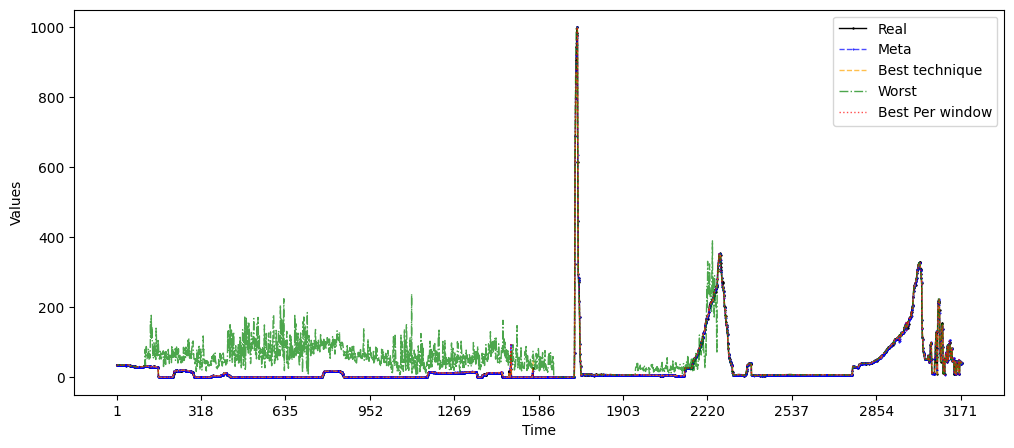

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


subset = df_real[(df_real.index == '9_distillate-flow') & (df_real['possition_isnan'] == 1)].drop('possition_isnan', axis=1).iloc[200:,:]
# Define o gráfico principal
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plotando todas as séries no gráfico principal
for col in subset.columns:
    if col == "Real":
        subset[col].plot(ax=ax1, label=col, linewidth=1, color="black",marker='+',markersize=1)
    elif col == "Meta":
        subset[col].plot(ax=ax1, label="Meta", linestyle="--", linewidth=1, color="blue",marker='*',markersize=1, alpha=0.7)
    elif col == "Best technique":
        subset[col].plot(ax=ax1, label="Best technique", linestyle="--", linewidth=1, color="orange", alpha=0.7)
    elif col == "Worst":
        subset[col].plot(ax=ax1, label="Worst", linestyle="-.", linewidth=1, color="green", alpha=0.7)
    elif col == "Best Per window":
        subset[col].plot(ax=ax1, label="Best Per window", linestyle=":", linewidth=1, color="red", alpha=0.7)

# Configurações do gráfico principal
# ax1.set_title("Comparação Completa de Real com Meta, Others, Worst e Best")
ax1.legend()
ax1.set_ylabel("Values")

# Define rótulos simples para o eixo x principal (apenas alguns pontos)
ax1.set_xticks(range(0, len(subset), max(1, len(subset) // 10)))
ax1.set_xticklabels(range(1, len(subset) + 1, max(1, len(subset) // 10)))
ax1.set_xlabel("Time") 

# Define o número de amostras para o zoom e normaliza o intervalo de dados
zoom_range = 50  # Número de amostras iniciais para o zoom
subset_zoom = subset.iloc[:zoom_range]  # Dados para o zoom
subset_zoom_normalized = subset_zoom/subset_zoom.to_numpy().max() #(subset_zoom - subset_zoom.min()) / (subset_zoom.max() - subset_zoom.min())  # Normaliza de 0 a 1

plt.show()


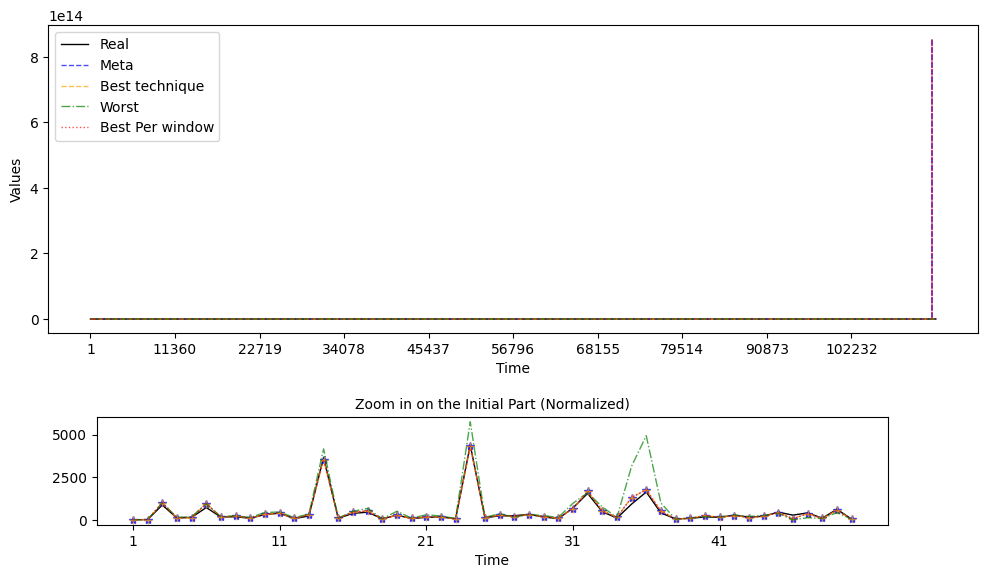

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

subset = df_real[(df_real.index == '0_LD2011_2014') & (df_real['possition_isnan'] == 1)].drop('possition_isnan', axis=1)

# Define o gráfico principal
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotando todas as séries no gráfico principal
for col in subset.columns:
    if col == "Real":
        subset[col].plot(ax=ax1, label=col, linewidth=1, color="black")
    elif col == "Meta":
        subset[col].plot(ax=ax1, label="Meta", linestyle="--", linewidth=1, color="blue", alpha=0.7)
    elif col == "Best technique":
        subset[col].plot(ax=ax1, label="Best technique", linestyle="--", linewidth=1, color="orange", alpha=0.7)
    elif col == "Worst":
        subset[col].plot(ax=ax1, label="Worst", linestyle="-.", linewidth=1, color="green", alpha=0.7)
    elif col == "Best Per window":
        subset[col].plot(ax=ax1, label="Best Per window", linestyle=":", linewidth=1, color="red", alpha=0.7)

# Configurações do gráfico principal
# ax1.set_title("Comparação Completa de Real com Meta, Others, Worst e Best")
ax1.legend()
ax1.set_ylabel("Values")

# Define rótulos simples para o eixo x principal (apenas alguns pontos)
ax1.set_xticks(range(0, len(subset), max(1, len(subset) // 10)))
ax1.set_xticklabels(range(1, len(subset) + 1, max(1, len(subset) // 10)))
ax1.set_xlabel("Time") 


# Define o número de amostras para o zoom e normaliza o intervalo de dados
zoom_range = 50  # Número de amostras iniciais para o zoom
subset_zoom = subset.iloc[:zoom_range]  # Dados para o zoom
subset_zoom_normalized = subset_zoom
# Adiciona um plot (janela de zoom) na posição mais baixa possível à direita
ax_inset = inset_axes(ax1, width="85%", height="70%", bbox_to_anchor=(-.09, -.75, 1., 0.5), bbox_transform=ax1.transAxes)

# Plotando as mesmas séries normalizadas na janela de zoom com as mesmas configurações de linha e sem legenda
for col in subset.columns:
    if col == "Real":
        subset_zoom_normalized[col].plot(ax=ax_inset, linewidth=1,color="black")
    elif col == "Meta":
        subset_zoom_normalized[col].plot(ax=ax_inset, linestyle="--", marker="*", linewidth=.5, color="blue", alpha=0.7)
    elif col == "Best technique":
        subset_zoom_normalized[col].plot(ax=ax_inset, linestyle="--", linewidth=1, marker="+", color="orange", alpha=0.7)
    elif col == "Worst":
        subset_zoom_normalized[col].plot(ax=ax_inset, linestyle="-.", linewidth=1, color="green", alpha=0.7)
    elif col == "Best Per window":
        subset_zoom_normalized[col].plot(ax=ax_inset, linestyle=":", linewidth=1, color="red", alpha=0.7)

# Configurações do gráfico de zoom
ax_inset.set_title("Zoom in on the Initial Part (Normalized)", fontsize=10)
ax_inset.set_xlabel("")  # Remove o rótulo do eixo x
ax_inset.set_ylabel("")  # Remove o rótulo do eixo y


# Verifica se a legenda existe e a remove
# legend = ax_inset.get_legend()
# if legend is not None:
#     legend.remove()

# Define rótulos simples para o eixo x da janela de zoom
ax_inset.set_xticks(range(0, zoom_range, max(1, zoom_range // 5)))
ax_inset.set_xticklabels(range(1, zoom_range + 1, max(1, zoom_range // 5)))
ax_inset.set_xlabel("Time") 
plt.show()


Teste with window 512

/tmp/ipykernel_2046200/1735420963.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smapes2['serie'] = ["".join(s.split('_')[1:]) for s in data['serie']]
/home/mauricio/.conda/envs/pyt_envmau/lib/python3.10/site-packages/torch/nn/modules/rnn.py:88: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


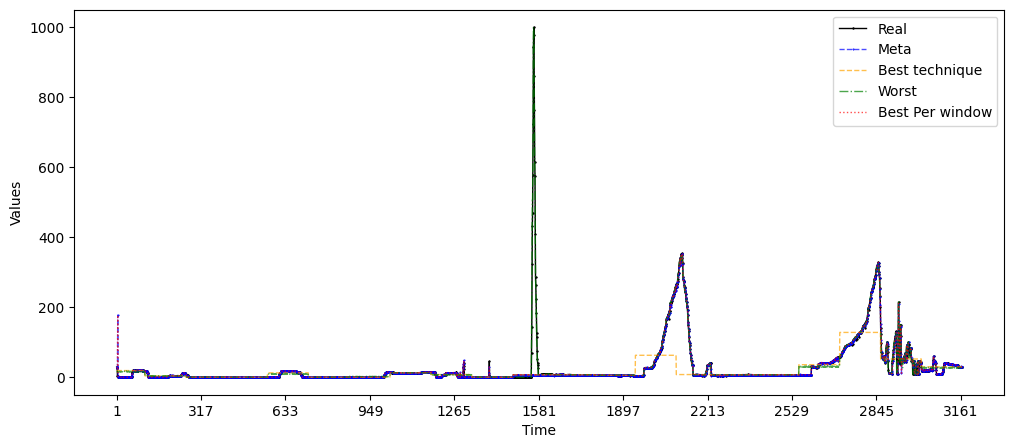

In [ ]:

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
experiment_dir='./imputation_Statistics/experiments/30/512'
wind = int(experiment_dir.split('/')[-1])
batch_size = 512  # Ajuste conforme necessário

df_inp = pd.read_csv('imputation_Statistics/experiments/30/512/teste/imputed/all_imputed.csv',low_memory=False)
df_real = pd.read_csv('imputation_Statistics/experiments/30/512/teste/imputed/real_full_data.csv', low_memory=False)

df_real.rename({'0':'Real'},axis='columns',inplace=True)

data_file = os.path.join(experiment_dir, 'teste', 'imputed', 'data_full_processed.csv')
data = pd.read_csv(data_file)
smapes2 = data[[col for col in data.columns if 'smape' in col]]
smapes2['serie'] = ["".join(s.split('_')[1:]) for s in data['serie']]
smapes2.set_index('serie',inplace=True)

full_serie = pd.DataFrame([data[[col for col in data.columns if 'smape' in col] + ['serie']].groupby('serie').mean().index,
                          np.argmin(data[[col for col in data.columns if 'smape' in col] + ['serie']].groupby('serie').mean(),axis=1)])
full_serie =full_serie.T
full_serie.rename({0:'serie',1:'class'},axis='columns',inplace=True)
worst = np.argmax(smapes2,axis=1)

#preapara espaço para os valores predict , piores e valores usnado uma técnica 
arr = np.zeros(df_real.shape[0])
df_real['Meta'] = arr
df_real['Best technique'] = arr
df_real['Worst'] = arr
df_inp['Best Per window']= arr



    
# Calcular valores mínimos e máximos para normalização usando apenas o experimento atual
min_values, max_values = compute_min_max_values([experiment_dir], wind=wind)

# Carregar DataLoaders de treino, validação e teste
_, _, test_loader = load_single_experiment_data(
    experiment_dir, wind= wind, batch_size=batch_size,
    min_values=min_values, max_values=max_values
)

# Diretório para salvar os modelos
model_dir = 'models'

# Early Stopping com caminho atualizado
model_path = os.path.join(model_dir, f"best_model_{experiment_dir.replace('/', '_')}_wind_{wind}.pt")
model = HybridLSTM(wind, 11, 11).to(device)
# Carregar o melhor modelo salvo pelo early stopping
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()


with torch.no_grad():

    multiclass_outputs_test = []
    multiclass_targets_test = []
    for batch_x, batch_y_multilabel, batch_y_multiclass in test_loader:
        batch_x = batch_x.to(device)
        batch_y_multilabel = batch_y_multilabel.to(device)
        batch_y_multiclass = batch_y_multiclass.to(device)

        outputs_multilabel, outputs_multiclass = model(batch_x)

        # Precisão multiclass
        _, predicted_multiclass = torch.max(outputs_multiclass, 1)

        # Armazenando as saídas e alvos multiclass
        multiclass_outputs_test.append(predicted_multiclass.cpu().numpy())
        multiclass_targets_test.append(batch_y_multiclass.cpu().numpy())
        
    multiclass_outputs_test = np.concatenate(multiclass_outputs_test)
    multiclass_targets_test = np.concatenate(multiclass_targets_test)
    


c = 0
for i in range(0, df_inp.shape[0] - 512, 512):
    patch_inp = df_inp.iloc[i:i + 512, :]
    p = patch_inp.iloc[:, multiclass_outputs_test[c]].values
    b = patch_inp.iloc[:, multiclass_targets_test[c]].values
    w = patch_inp.iloc[:, worst[c]].values

    df_real.loc[i:i + 511, 'Worst'] = w  
    df_real.loc[i:i + 511, 'Meta'] = p
    df_real.loc[i:i + 511, 'Best Per window'] = p
    c += 1


df_inp.set_index('serie',inplace=True)
full_serie.set_index('serie',inplace=True)
df_real.set_index('serie',inplace=True)

for s in full_serie.index:
    v = full_serie.loc[s].values[0]
    temp = df_inp.loc[s].iloc[:,v]
    df_real.loc[s,'Best technique']=temp.values


selected_data = np.isnan(test_loader.dataset.data.iloc[:,1:513].to_numpy().flatten()).astype(int)
df_real['possition_isnan']=selected_data


subset = df_real[(df_real.index == '9_distillate-flow') & (df_real['possition_isnan'] == 1)].drop('possition_isnan', axis=1).iloc[200:,:]

# Define o gráfico principal
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plotando todas as séries no gráfico principal
for col in subset.columns:
    if col == "Real":
        subset[col].plot(ax=ax1, label=col, linewidth=1, color="black",marker='+',markersize=1)
    elif col == "Meta":
        subset[col].plot(ax=ax1, label="Meta", linestyle="--", linewidth=1, color="blue",marker='*',markersize=1, alpha=0.7)
    elif col == "Best technique":
        subset[col].plot(ax=ax1, label="Best technique", linestyle="--", linewidth=1, color="orange", alpha=0.7)
    elif col == "Worst":
        subset[col].plot(ax=ax1, label="Worst", linestyle="-.", linewidth=1, color="green", alpha=0.7)
    elif col == "Best Per window":
        subset[col].plot(ax=ax1, label="Best Per window", linestyle=":", linewidth=1, color="red", alpha=0.7)

# Configurações do gráfico principal
# ax1.set_title("Comparação Completa de Real com Meta, Others, Worst e Best")
ax1.legend()
ax1.set_ylabel("Values")

# Define rótulos simples para o eixo x principal (apenas alguns pontos)
ax1.set_xticks(range(0, len(subset), max(1, len(subset) // 10)))
ax1.set_xticklabels(range(1, len(subset) + 1, max(1, len(subset) // 10)))
ax1.set_xlabel("Time") 

# Define o número de amostras para o zoom e normaliza o intervalo de dados
zoom_range = 50  # Número de amostras iniciais para o zoom
subset_zoom = subset.iloc[:zoom_range]  # Dados para o zoom
subset_zoom_normalized = subset_zoom/subset_zoom.to_numpy().max() 

plt.show()

Comparassion between all methods and Meta

In [117]:
meta1024 = [smapes.iloc[i,out1024[i]] for i in range(smapes.shape[0])]
meta512 = [smapes2.iloc[i,multiclass_outputs_test[i]] for i in range(smapes2.shape[0])]

smapes['Meta'],smapes2['Meta']  = meta1024 , meta512

/tmp/ipykernel_2046200/2571290149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smapes['Meta'],smapes2['Meta']  = meta1024 , meta512


In [123]:
smapes = smapes.groupby(smapes.index).mean()

In [ ]:
smapes2 = smapes2.groupby(smapes2.index).mean()
smapes2 = smapes2.loc[smapes.index,:]


In [137]:

# Supondo que smapes e smapes2 são os dois DataFrames
# Primeiro, encontramos as colunas comuns e as colunas exclusivas de cada DataFrame
colunas_comuns = smapes.columns.intersection(smapes2.columns)
colunas_unicas_df1 = smapes.columns.difference(smapes2.columns)
colunas_unicas_df2 = smapes2.columns.difference(smapes.columns)

# Parte 1: Somar e tirar a média das colunas comuns
df_media = (smapes[colunas_comuns] + smapes2[colunas_comuns]) / 2

# Parte 2: Adicionar as colunas exclusivas de ambos os DataFrames ao DataFrame da média
df_resultado = pd.concat([df_media, smapes[colunas_unicas_df1], smapes2[colunas_unicas_df2]], axis=1)

# Opcional: ordene as colunas se necessário
df_resultado = df_resultado.reindex(sorted(df_resultado.columns), axis=1)

# Exibindo o resultado



In [138]:
df_resultado.head()

,Meta,asmape_backfill,asmape_ffill,asmape_inter_akima,asmape_inter_cubic,asmape_inter_linear,asmape_inter_poly5,asmape_inter_spline5,asmape_mean,asmape_mean_mov_3,asmape_median,asmape_moment,asmape_pix
serie,,,,,,,,,,,,,
Bike Sharing,24.878562,27.919940,144.829021,29.854842,123.763078,23.073848,117.109163,27.990300,22.712066,116.163461,1.286733e+06,38.215205,29.605930
LD20112014,5.467734,7.002182,424.542160,7.207019,274.029955,7.553591,268.026023,7.005747,7.165599,269.003794,5.681090e+27,16.355101,6.082480
Sunspots,12.761138,21.917001,33.620268,20.755383,12.606221,27.647881,13.072416,21.804634,28.226866,13.029111,3.680111e+01,39.687851,44.173167
daily-minimum-temperatures-in-me,2.131779,10.932843,2.353557,10.779512,2.245772,10.914002,2.263520,10.894975,12.723508,2.264049,3.311534e+00,14.681130,7.263865
distillate-flow,18.965090,13.213605,48.928087,13.602591,1.050773,37.469273,1.037464,13.323212,37.226258,1.033410,1.029241e+00,47.129912,70.324047


In [ ]:
df_resultado.to_csv('reultadobetween.csv')

: 